In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_device('cpu')

import numpy as np

from transformers_simple.fcn import FCN
from transformers_simple.train import Trainer
from transformers_simple.dataset import CharDataset
from transformers_simple.char_util import generate_sample

In [2]:
N = 4

block_size  = 2
embed_size  = 6
hidden_size = 30
num_layers = 3

vocab_size  = 3
input_size = block_size*embed_size
output_size = vocab_size

log_interval = 50
epochs = 5
learning_rate = 1e-4
device = torch.device('cpu')

In [3]:
# #block size 1
# data = "".join(["abca"]*1000)

In [4]:
# block size 2
data = "".join(["aabcacb"]*1000)

In [5]:
Ns = int(len(data)*0.5)

data_train = data[:Ns]
data_test = data[Ns:]

dataset_train = CharDataset(data=data_train, block_size=block_size)
dataset_test = CharDataset(data=data_test, block_size=block_size)
dataset_train[0]

(tensor([0, 0]), tensor([0, 1]))

In [6]:
class AdapterNet(torch.nn.Module):
    def __init__(self, net):
        super(AdapterNet,self).__init__()
        self.net = net
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        
    def forward(self, x):
        nb, l = x.size()

        o = self.embedding(x)
        o = o.view(nb,-1)
        o = self.net(o)

        return o
    
net = FCN(input_size=input_size, output_size=output_size, 
          hidden_size=hidden_size, num_layers=num_layers)

model = AdapterNet(net)

In [7]:
x = dataset_train[0][0].view(1,-1)

In [8]:
o = model(x)
o.size()

torch.Size([1, 3])

In [9]:
loss = torch.nn.CrossEntropyLoss()

def loss_fn(o,y):
    return loss(o,y[:,-1])

In [10]:
trainer = Trainer(model=model, 
                  dataset=dataset_train, 
                  loss_fn=loss_fn, 
                  batch_size=N, 
                  learning_rate=learning_rate,
                  epochs=epochs, 
                  log_interval=log_interval, 
                  device=device,
                    val_dataset=dataset_test,
                 val_interval=100)

In [11]:
trainer.run()

Train Epoch: 0 [0/3498 (0%)]	Loss: 1.025071


875it [00:00, 1665.55it/s]


Train Epoch: 0 [200/3498 (6%)]	Loss: 1.073488
Train Epoch: 0 [400/3498 (11%)]	Loss: 1.110734


875it [00:00, 1712.90it/s]


Train Epoch: 0 [600/3498 (17%)]	Loss: 1.115690
Train Epoch: 0 [800/3498 (23%)]	Loss: 1.100570


875it [00:00, 1699.69it/s]


Train Epoch: 0 [1000/3498 (29%)]	Loss: 1.081288
Train Epoch: 0 [1200/3498 (34%)]	Loss: 1.034391


875it [00:00, 1589.08it/s]


Train Epoch: 0 [1400/3498 (40%)]	Loss: 1.068278
Train Epoch: 0 [1600/3498 (46%)]	Loss: 0.672237


875it [00:00, 1719.44it/s]


Train Epoch: 0 [1800/3498 (51%)]	Loss: 0.717770
Train Epoch: 0 [2000/3498 (57%)]	Loss: 0.750303


875it [00:00, 1649.62it/s]


Train Epoch: 0 [2200/3498 (63%)]	Loss: 0.740356
Train Epoch: 0 [2400/3498 (69%)]	Loss: 0.624025


875it [00:00, 1653.26it/s]


Train Epoch: 0 [2600/3498 (74%)]	Loss: 0.256172
Train Epoch: 0 [2800/3498 (80%)]	Loss: 0.551687


875it [00:00, 1725.49it/s]


Train Epoch: 0 [3000/3498 (86%)]	Loss: 0.256484
Train Epoch: 0 [3200/3498 (91%)]	Loss: 0.519375


875it [00:00, 1583.85it/s]


Train Epoch: 0 [3400/3498 (97%)]	Loss: 0.123391
Train Epoch: 1 [0/3498 (0%)]	Loss: 0.120632


875it [00:00, 1705.49it/s]


Train Epoch: 1 [200/3498 (6%)]	Loss: 0.053434
Train Epoch: 1 [400/3498 (11%)]	Loss: 0.127116


875it [00:00, 1638.04it/s]


Train Epoch: 1 [600/3498 (17%)]	Loss: 0.030672
Train Epoch: 1 [800/3498 (23%)]	Loss: 0.068141


875it [00:00, 1653.59it/s]


Train Epoch: 1 [1000/3498 (29%)]	Loss: 0.064988
Train Epoch: 1 [1200/3498 (34%)]	Loss: 0.012222


875it [00:00, 1658.76it/s]


Train Epoch: 1 [1400/3498 (40%)]	Loss: 0.053939
Train Epoch: 1 [1600/3498 (46%)]	Loss: 0.023779


875it [00:00, 1648.77it/s]


Train Epoch: 1 [1800/3498 (51%)]	Loss: 0.003880
Train Epoch: 1 [2000/3498 (57%)]	Loss: 0.005731


875it [00:00, 1656.37it/s]


Train Epoch: 1 [2200/3498 (63%)]	Loss: 0.015393
Train Epoch: 1 [2400/3498 (69%)]	Loss: 0.003033


875it [00:00, 1707.69it/s]


Train Epoch: 1 [2600/3498 (74%)]	Loss: 0.003661
Train Epoch: 1 [2800/3498 (80%)]	Loss: 0.005165


875it [00:00, 1707.62it/s]


Train Epoch: 1 [3000/3498 (86%)]	Loss: 0.009710
Train Epoch: 1 [3200/3498 (91%)]	Loss: 0.004706


875it [00:00, 1671.01it/s]


Train Epoch: 1 [3400/3498 (97%)]	Loss: 0.005859
Train Epoch: 2 [0/3498 (0%)]	Loss: 0.002258


875it [00:00, 1638.14it/s]


Train Epoch: 2 [200/3498 (6%)]	Loss: 0.003668
Train Epoch: 2 [400/3498 (11%)]	Loss: 0.003952


875it [00:00, 1703.96it/s]


Train Epoch: 2 [600/3498 (17%)]	Loss: 0.001027
Train Epoch: 2 [800/3498 (23%)]	Loss: 0.007315


875it [00:00, 1708.22it/s]


Train Epoch: 2 [1000/3498 (29%)]	Loss: 0.005331
Train Epoch: 2 [1200/3498 (34%)]	Loss: 0.003076


875it [00:00, 1693.97it/s]


Train Epoch: 2 [1400/3498 (40%)]	Loss: 0.002303
Train Epoch: 2 [1600/3498 (46%)]	Loss: 0.000700


875it [00:00, 1512.52it/s]


Train Epoch: 2 [1800/3498 (51%)]	Loss: 0.001390
Train Epoch: 2 [2000/3498 (57%)]	Loss: 0.000904


875it [00:00, 1604.60it/s]


Train Epoch: 2 [2200/3498 (63%)]	Loss: 0.001689
Train Epoch: 2 [2400/3498 (69%)]	Loss: 0.000433


875it [00:00, 1486.80it/s]


Train Epoch: 2 [2600/3498 (74%)]	Loss: 0.000758
Train Epoch: 2 [2800/3498 (80%)]	Loss: 0.000414


875it [00:00, 1653.72it/s]


Train Epoch: 2 [3000/3498 (86%)]	Loss: 0.002030
Train Epoch: 2 [3200/3498 (91%)]	Loss: 0.001097


875it [00:00, 1646.42it/s]


Train Epoch: 2 [3400/3498 (97%)]	Loss: 0.001192
Train Epoch: 3 [0/3498 (0%)]	Loss: 0.000554


875it [00:00, 1625.70it/s]


Train Epoch: 3 [200/3498 (6%)]	Loss: 0.000879
Train Epoch: 3 [400/3498 (11%)]	Loss: 0.000471


875it [00:00, 1663.85it/s]


Train Epoch: 3 [600/3498 (17%)]	Loss: 0.000442
Train Epoch: 3 [800/3498 (23%)]	Loss: 0.000870


875it [00:00, 1663.37it/s]


Train Epoch: 3 [1000/3498 (29%)]	Loss: 0.000474
Train Epoch: 3 [1200/3498 (34%)]	Loss: 0.000698


875it [00:00, 1663.20it/s]


Train Epoch: 3 [1400/3498 (40%)]	Loss: 0.000666
Train Epoch: 3 [1600/3498 (46%)]	Loss: 0.000806


875it [00:00, 1643.26it/s]


Train Epoch: 3 [1800/3498 (51%)]	Loss: 0.000324
Train Epoch: 3 [2000/3498 (57%)]	Loss: 0.000596


875it [00:00, 1592.70it/s]


Train Epoch: 3 [2200/3498 (63%)]	Loss: 0.000164
Train Epoch: 3 [2400/3498 (69%)]	Loss: 0.000477


875it [00:00, 1647.51it/s]


Train Epoch: 3 [2600/3498 (74%)]	Loss: 0.000146
Train Epoch: 3 [2800/3498 (80%)]	Loss: 0.000244


875it [00:00, 1627.04it/s]


Train Epoch: 3 [3000/3498 (86%)]	Loss: 0.000279
Train Epoch: 3 [3200/3498 (91%)]	Loss: 0.000205


875it [00:00, 1707.34it/s]


Train Epoch: 3 [3400/3498 (97%)]	Loss: 0.000122
Train Epoch: 4 [0/3498 (0%)]	Loss: 0.000107


875it [00:00, 1659.06it/s]


Train Epoch: 4 [200/3498 (6%)]	Loss: 0.000343
Train Epoch: 4 [400/3498 (11%)]	Loss: 0.000605


875it [00:00, 1657.87it/s]


Train Epoch: 4 [600/3498 (17%)]	Loss: 0.000098
Train Epoch: 4 [800/3498 (23%)]	Loss: 0.000373


875it [00:00, 1653.29it/s]


Train Epoch: 4 [1000/3498 (29%)]	Loss: 0.000090
Train Epoch: 4 [1200/3498 (34%)]	Loss: 0.000106


875it [00:00, 1671.10it/s]


Train Epoch: 4 [1400/3498 (40%)]	Loss: 0.000251
Train Epoch: 4 [1600/3498 (46%)]	Loss: 0.000076


875it [00:00, 1662.45it/s]


Train Epoch: 4 [1800/3498 (51%)]	Loss: 0.000237
Train Epoch: 4 [2000/3498 (57%)]	Loss: 0.000229


875it [00:00, 1586.16it/s]


Train Epoch: 4 [2200/3498 (63%)]	Loss: 0.000251
Train Epoch: 4 [2400/3498 (69%)]	Loss: 0.000103


875it [00:00, 1591.71it/s]


Train Epoch: 4 [2600/3498 (74%)]	Loss: 0.000102
Train Epoch: 4 [2800/3498 (80%)]	Loss: 0.000059


875it [00:00, 1552.37it/s]


Train Epoch: 4 [3000/3498 (86%)]	Loss: 0.000124
Train Epoch: 4 [3200/3498 (91%)]	Loss: 0.000152


875it [00:00, 1719.62it/s]


Train Epoch: 4 [3400/3498 (97%)]	Loss: 0.000272


In [12]:
x = dataset_train[0][0].view(1,-1)

o = model(x)

In [13]:
torch.nn.functional.softmax(o, dim=1)

tensor([[3.9271e-09, 9.9993e-01, 6.5703e-05]], grad_fn=<SoftmaxBackward0>)

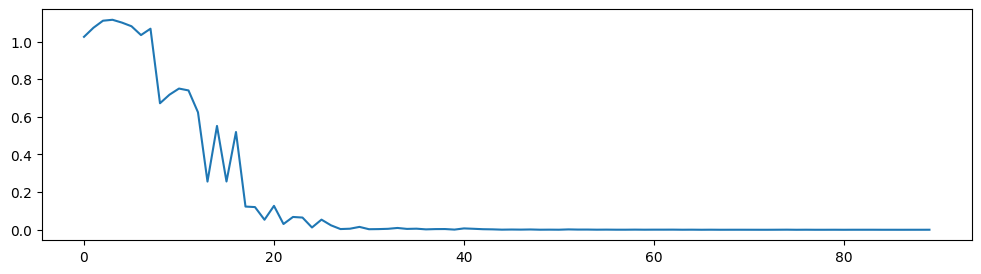

In [14]:
loss_history = trainer.loss_history

plt.figure(figsize=(12,3))
plt.plot(loss_history)
plt.show()

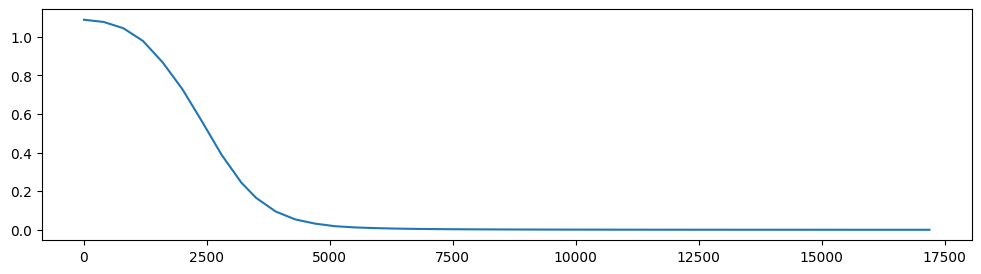

In [15]:
plt.figure(figsize=(12,3))
plt.plot(trainer.val_loss_iters, trainer.val_loss_history)
plt.show()

In [16]:
x = [0,1]
T = 20

o = generate_sample(x, model, length=T)

In [17]:
o

[2, 0, 2, 1, 0, 0, 1, 2, 0, 2, 1, 0, 0, 1, 2, 0, 2, 1, 0, 0]